In [1]:
# Takes 2.10 minutes to run
import warnings
warnings.filterwarnings('ignore')
from support._model_build_func import *


Labels
 1        1016
-1        1004
 0         883
dtype: int64


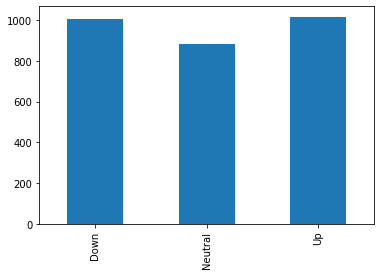

In [2]:
Variables = Variables_.copy(deep=True)
Response = Response_.copy(deep=True)
Variables_midx = Variables_midx_.copy(deep=True)
last_valid_loc = last_valid_loc_.copy(deep=True)
Variables_with_nans = Variables_with_nans_

len(Variables), len(Response), Variables.shape, Response.shape

pv_1 = 0.0025 # higher and lower than 0.25% return
pv_2 = 0.0075 # higher and lower than 1% return
col = 'Adj_Close_ret' # Can also be 'Close_ret'

num_classes = 3 # Choose 3 or 5
Response = get_multiclass_labels(num_classes,pv_1,pv_2, Response,col)

X_train_dict, X_test_dict, X_val_dict, y_train, y_test, y_val, sample_weights_train, sample_weights_test, sample_weights_val \
    = ttv_split(Variables, Response, test_size=0.50, Validation_date_start = '2022-01-01')

In [6]:
def add_to_features_df(model,dataset):
    model_name = type(model).__name__
    features_df.loc[(model_name, dataset),'Num_Features'] = len(X_train_dict[dataset].columns) # so can store list of features
    features_df.loc[(model_name, dataset),'Features_List'] = X_train_dict[dataset].columns.to_list()

    original_list = set(features_df.loc[(model_name, 'Original'),'Features_List'])
    dataset_list = set(features_df.loc[(model_name, dataset),'Features_List'])
    removed_list = list(sorted(original_list - dataset_list))
    
    features_df.loc[(model_name, dataset),'Removed_Features'] = removed_list
    features_df.loc[(model_name, dataset),'Model_Details'] = model

def get_shapes(dataset):
    # print("\nShapes for dataset:",dataset)
    print("X_train Shape",X_train_dict[dataset].shape)
    print("X_test Shape",X_test_dict[dataset].shape)
    print("X_val Shape",X_val_dict[dataset].shape)
    # print("y_train Shape",y_train.shape)
    # print("y_test Shape",y_test.shape)
    # print("y_val Shape",y_val.shape)

def print_pipe_removed(pipe):
    total_removed = 0
    # print("\nRemoved Features for Pipeline:",pipe)
    for i in range(len(pipe.steps)):
        step_name = pipe.steps[i][0]
        total_removed += len(pipe.named_steps[step_name].features_to_drop_)
        print(step_name, ":",len(pipe.named_steps[step_name].features_to_drop_))
    print("Total removed:",total_removed)

# Calls all the above 3 functions
def insert_and_print(model,dataset,pipe, manual_list):
    print("\nInserting Pipeline for dataset:",dataset)

    # This code INSERTS model's basic data into features_df
    add_to_features_df(model,dataset)

    # This code PRINTS X variables Shape
    get_shapes(dataset)

    # This code prints the features removed for each pipe step
    if not manual_list: print_pipe_removed(pipe)
  


# this func first fits the transformation to all indices of X_train from cv (btscv), then transforms the features from X_train, X_test and X_val
# For each pipeline trasnformation, we are using same sample_weights_train - Not working
def transform_features_space(dataset,pipe,sampled_weights=False):
    print("\nRemoving Features for dataset:",dataset)
    print("# Features before:",len(X_train_dict[dataset].columns.to_list()))
    

    X, y = get_x_y_sets(dataset,X_train_dict,X_test_dict,y_train,y_test,set='combined')
    train_idx = get_cv_indices(BlockingTimeSeriesSplit, X, y, n_splits= 5, flatten = True)['train']
    
    # Since this is not working sampled_weights True is same as False
    if sampled_weights:

        # NOT WORKING
        # parameters = {pipe.steps[i][0] + "__sample_weight": y.iloc[train_idx].sample_weights.values for i in range(len(pipe.steps))}
        # pipe.fit(X.iloc[train_idx], **parameters)
        pipe.fit(X.iloc[train_idx])
    else:
        pipe.fit(X.iloc[train_idx])
        
    X_train_dict[dataset] = pipe.transform(X_train_dict[dataset])
    X_test_dict[dataset] = pipe.transform(X_test_dict[dataset])
    X_val_dict[dataset] = pipe.transform(X_val_dict[dataset])

# This func is only to initialize the X variables with some features set - typically, we use 'Original' if not passed in
def fill_with_dataset(dataset,manual_list, original_dataset = 'Original'):
    if manual_list:
        X_train_dict[dataset] = X_train_dict[original_dataset][manual_list]
        X_test_dict[dataset] = X_test_dict[original_dataset][manual_list]
        X_val_dict[dataset] = X_val_dict[original_dataset][manual_list]
        
    else:
        X_train_dict[dataset] = X_train_dict[original_dataset]
        X_test_dict[dataset] = X_test_dict[original_dataset]
        X_val_dict[dataset] = X_val_dict[original_dataset]

# **cross_val_score - accuracy_score**                                                      
# scoring https://scikit-learn.org/stable/modules/model_evaluation.html#the-scoring-parameter-defining-model-evaluation-rules

def add_metrics(model,dataset,X_train_dict,X_test_dict,y_train,y_test,set='combined', sampled_weights=False):

    model_name = type(model).__name__
    metrics_list = ['balanced_accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted','neg_log_loss']

    # Using BlockedTimeSeriesSplit cross val to calculate metrics
    X, y = get_x_y_sets(dataset,X_train_dict,X_test_dict,y_train,y_test, set='combined')

    for metric in metrics_list:

        if sampled_weights:
        # cross_val_score with SAMPLE_WEIGHTS
            score = cross_val_score(model, X, y.Labels, cv=btscv, scoring = str(metric),fit_params={'sample_weight':y.sample_weights.values}) #,error_score="raise"
        else:
            score = cross_val_score(model, X, y.Labels, cv=btscv, scoring = str(metric)) #,error_score="raise"
            
        features_df.loc[(model_name, dataset),metric]= round(np.mean(score),2)

    # Calculating Class Wise Metrics - although predictions_from_custom_cross_val uses sample_weights to fit & predict but the metrics_from_cm doesn't use sample_weights
    original, predicted = predictions_from_custom_cross_val(model,X, y, custom_cv = btscv, sampled_weights=sampled_weights)
    cm = pd.DataFrame(confusion_matrix(original, predicted), index=Response['Labels'].unique(), columns=Response['Labels'].unique())
    all_class_metric = metrics_from_cm(cm, lab = sorted(Response['Labels'].unique()))

    # Calculating pnl_score & sharpe - Adj_Close_ret is Log Returns so can simply add them after multiplying with predictions
    Test_adj_returns = y.Adj_Close_ret.iloc[get_cv_indices(BlockingTimeSeriesSplit, X, y, n_splits= 5)['test']].values.tolist()
    return_list = [a*b for a,b in zip(Test_adj_returns,predicted)]
    return_std = np.std(return_list)
    pnl_score = np.sum(return_list)
    sharpe_ratio = (pnl_score - 0.0)/return_std
    features_df.loc[(model_name, dataset),'pnl'] = pnl_score
    features_df.loc[(model_name, dataset),'sharpe'] = sharpe_ratio * np.sqrt(252) # Annualized


    # Calculating Kappa Score 
    if sampled_weights:
    # Kappa with SAMPLE_WEIGHTS
        sample_weights = y.sample_weights.iloc[get_cv_indices(BlockingTimeSeriesSplit, X, y, n_splits= 5)['test']].values.tolist()
        kappa_score = cohen_kappa_score(original, predicted, sample_weight=sample_weights)
    else:
        kappa_score = cohen_kappa_score(original, predicted)
    
    features_df.loc[(model_name, dataset),'Kappa']= kappa_score
    
    # Insert the dataframe in a cell in features_df
    features_df.loc[(model_name, dataset),'ClassDf'] = np.array([])
    features_df.loc[(model_name, dataset),'ClassDf'].astype(object)
    features_df.loc[(model_name, dataset),'ClassDf'] =  [all_class_metric]
        

Labels
 1        961
-1        947
 0        863
dtype: int64
Labels
 1        961
-1        947
 0        863
dtype: int64
X_train Shape (1385, 762)
X_test Shape (1386, 762)
X_val Shape (132, 762)


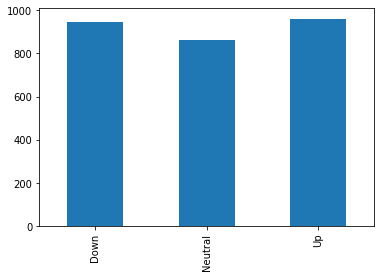

In [8]:
# Not using xgb_clf for now because it is too slow

btscv = BlockingTimeSeriesSplit(n_splits=5)
rf_clf = RandomForestClassifier(n_estimators=200, max_depth=3, n_jobs=-1)
xgb_clf = XGBClassifier(n_estimators=100, max_depth=3, n_jobs=-1,eval_metric='mlogloss')

models = [rf_clf,xgb_clf]
# models = [rf_clf]

model_names = [type(m).__name__ for m in models]
dataset = 'Original'
multilevel_index = pd.MultiIndex.from_product([model_names,[dataset]],names=['Model', 'Dataset'])
cols_names = ['Model_Details','Num_Features','Features_List','Removed_Features'] + ['balanced_accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted','neg_log_loss','Kappa','pnl','sharpe','ClassDf']
features_df = pd.DataFrame(columns=cols_names, index=multilevel_index)

# Takes 2 mins to run
for m in models:
    add_to_features_df(m,dataset='Original')
    add_metrics(model=m,dataset='Original',X_train_dict=X_train_dict,X_test_dict=X_test_dict,y_train=y_train,y_test=y_test,set='combined')
    
# Shapes
get_shapes(dataset = 'Original')

Labels
 1        961
-1        947
 0        863
dtype: int64


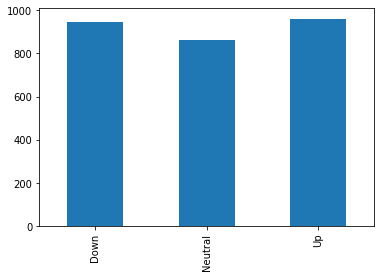

In [9]:
dataset = 'Original'
X, y = get_x_y_sets(dataset,X_train_dict,X_test_dict,y_train,y_test, set='combined')
X.columns = Variables_midx.columns
train_idx  = get_cv_indices(BlockingTimeSeriesSplit, X, y, n_splits= 5, flatten = True)['train']
test_idx = get_cv_indices(BlockingTimeSeriesSplit, X, y, n_splits= 5, flatten = True)['test']
X_train = X.iloc[train_idx]
y_train1 = y.iloc[train_idx]

top_cohort_variable = pd.DataFrame(index = Variables_midx.columns.get_level_values(0).unique(), columns=['Variable','Score','Col_name'])
for outer_col in Variables_midx.columns.get_level_values(0).unique():
    
    sel_  = SelectKBest(mutual_info_classif, k=1).fit(X_train.loc[:,(outer_col,)], y_train1.Labels)
    
    selected_col = [x for x,y in zip(pd.DataFrame(X_train.loc[:,(outer_col,)]).columns,sel_.get_support()) if y]
    # col_name = tuple(outer_col+','+selected_col[0])

    selected_col_score = [x for x,y in zip(sel_.scores_,sel_.get_support()) if y]
    # top_cohort_variable[outer_col] = [selected_col[0],selected_col_score[0]]
    # cols = pd.MultiIndex.from_product([[outer_col], (selected_col[0])])
    top_cohort_variable.loc[outer_col,'Variable'] = selected_col[0]
    top_cohort_variable.loc[outer_col,'Score'] = selected_col_score[0]

    try:
        top_cohort_variable.loc[outer_col,'Col_name'] = outer_col+" "+selected_col[0]
    except:
        print(outer_col, selected_col[0])

    # inner_cols = [x for x in pd.DataFrame(X_train.loc[:,(outer_col,)]).columns]    
    # print(sel_.scores_)
    # print(sel_.get_support())
    # print(outer_col,selected_col[0])
    # print(selected_col_score)
    # print(top_cohort_variable[outer_col])
    # print('\n')

    # TA_df.columns = [('TA_',x) for x in TA_df.columns]
    
# Make column names same as Variables
for col in top_cohort_variable.Col_name:
    top_cohort_variable.loc[top_cohort_variable['Col_name'] == col, 'Col_name'] = str(col).translate(str.maketrans('', '', string.punctuation)).lstrip().rstrip()

# Keeping only top 95% percentile of variables in terms of mutual info score - Enter 1- percentile value in the below line
top_cohort_variable = top_cohort_variable[top_cohort_variable.Score > top_cohort_variable.Score.quantile(.5)]
top_cohort_variable.sort_values(by=['Score'],ascending=False, inplace=True)


In [12]:
X = X_train_dict['Original'][top_cohort_variable.Col_name.values.tolist()]

In [13]:
y = y_train.Labels

array([ 1, -1,  1, ...,  1,  1,  0])

In [22]:
lab_list = y_train.Labels.values.tolist()   

In [40]:

x = StandardScaler().fit_transform(X)
y = StandardScaler().fit_transform([y_train.Labels.values])
Target = pd.DataFrame(['+ve' if i == 1 else '-ve' if i == -1 else '0' for i in lab_list])

In [41]:

from sklearn.decomposition import PCA
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2','principal component 3'])

In [42]:
finalDf = pd.concat([principalDf, Target], axis = 1)
finalDf.columns = ['principal component 1', 'principal component 2','principal component 3', 'Target']
finalDf.head(5)

,principal component 1,principal component 2,principal component 3,Target
0,-9.432237,-0.589897,-0.028292,+ve
1,24.403632,6.075438,-0.354063,-ve
2,7.447717,0.607296,0.225061,+ve
3,24.569331,4.037145,1.956486,-ve
4,-9.529871,-0.599618,-0.027042,-ve


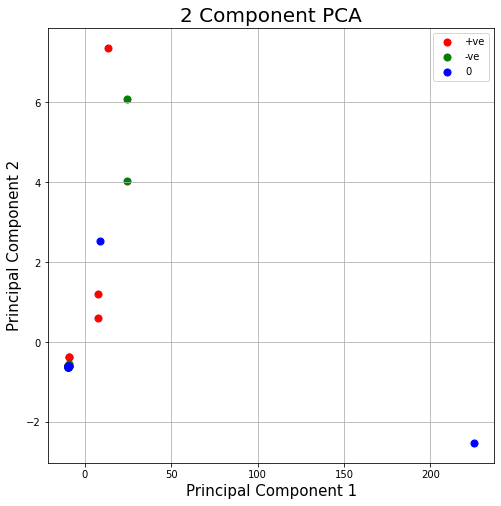

In [43]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)

targets = ['+ve', '-ve', '0']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1'], finalDf.loc[indicesToKeep, 'principal component 2'], c = color, s = 50)
ax.legend(targets)
ax.grid()

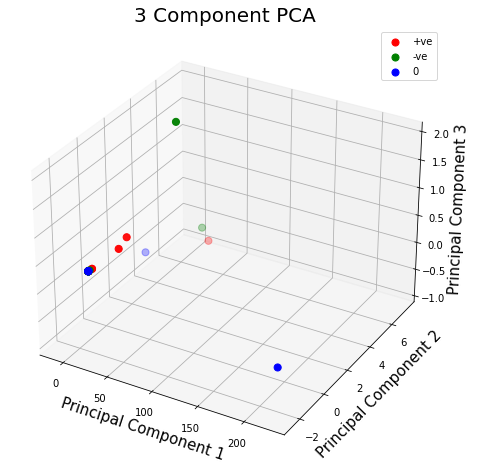

In [44]:
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (8,8))
ax = plt.axes(projection='3d')

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)
ax.set_title('3 Component PCA', fontsize = 20)

targets = ['+ve', '-ve', '0']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Target'] == target
    ax.scatter3D(finalDf.loc[indicesToKeep, 'principal component 1'], finalDf.loc[indicesToKeep, 'principal component 2'], finalDf.loc[indicesToKeep, 'principal component 3'], c = color, s = 50)
ax.legend(targets)
ax.grid()


In [39]:
finalDf['principal component 1'].dropna()

0       8.157784
1       8.164274
2       8.165167
3       8.146263
4       8.114880
          ...   
1380   -8.149609
1381   -8.201497
1382   -8.121279
1383   -8.156117
1384   -8.154224
Name: principal component 1, Length: 1385, dtype: float64